Sealevel monitor
========

This document is used to monitor the current sea level along the Dutch coast. The sea level is measured using a number of tide gauges. Six long running tide gauges are considered "main stations". The mean of these stations is used to estimate the "current sea-level rise". The measurements since 1890 are taken into account. Measurements before that are considered less valid because the Amsterdam Ordnance Datum was not yet normalized. 

In [1]:
# this is a list of packages that are used in this notebook
# these come with python
import io
import zipfile
import functools
import bisect
import datetime


# you can install these packages using pip or anaconda
# (requests numpy pandas bokeh pyproj statsmodels)

# for downloading
import requests
import netCDF4

# computation libraries
import numpy as np
import pandas


# coordinate systems
import pyproj 

# statistics
import statsmodels.api as sm

# plotting
import bokeh.charts
import bokeh.io
import bokeh.plotting
import bokeh.tile_providers
import bokeh.palettes

import windrose
import matplotlib.colors
import matplotlib.cm
import matplotlib.pyplot as plt
matplotlib.projections.register_projection(windrose.WindroseAxes)
print(matplotlib.projections.get_projection_names())
import cmocean.cm

# displaying things
from ipywidgets import Image
import IPython.display

['aitoff', 'hammer', 'lambert', 'mollweide', 'polar', 'rectilinear', 'windrose']


In [2]:
# Some coordinate systems
WEBMERCATOR = pyproj.Proj(init='epsg:3857')
WGS84 = pyproj.Proj(init='epsg:4326')

# If this notebook is not showing up with figures, you can use the following url:
# https://nbviewer.ipython.org/github/openearth/notebooks/blob/master/sealevelmonitor.ipynb
bokeh.io.output_notebook()
# we're using matplotlib for polar plots (non-interactive)
%matplotlib inline
# does not work properly
# %matplotlib notebook


Loading BokehJS ...

Sea-level explained  
=======
The sea-level is dependent on several factors. We call these factors explanatory, exogenuous or independent variables. The main factors that influence the monthly and annual sea level include wind, pressure, river discharge, tide and oscilations in the ocean. Based on previous analysis we include wind and nodal tide as independent variables. To be able to include wind, we use the monthly 10m wind based on the NCEP reanlysis of the NCAR. To be more specific we include the squared u and v wind components. Unfortunately the wind series only go back to 1948. To be able to include them without having to discard the sea level measurements before 1948, we fill in the missing data with the mean. 

We don't include timeseries of volume based explanatory variables like 

In [3]:
def make_wind_df(lat_i=53, lon_i=3):
    """create a dataset for wind, for 1 latitude/longitude"""
    u_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/uwnd.10m.mon.mean.nc'
    v_file = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/surface_gauss/vwnd.10m.mon.mean.nc'

    # open the 2 files
    ds_u = netCDF4.Dataset(u_file)
    ds_v = netCDF4.Dataset(v_file)
    # read lat,lon, time from 1 dataset
    lat, lon, time = ds_u.variables['lat'][:], ds_u.variables['lon'][:], ds_u.variables['time'][:]
    # check with the others
    lat_v, lon_v, time_v = ds_v.variables['lat'][:], ds_v.variables['lon'][:], ds_v.variables['time'][:]
    assert (lat == lat_v).all() and (lon == lon_v).all() and (time == time_v).all()
    # convert to datetime
    t = netCDF4.num2date(time, ds_u.variables['time'].units)
    
    def find_closest(lat, lon, lat_i=lat_i, lon_i=lon_i):
        """lookup the index of the closest lat/lon"""
        Lon, Lat = np.meshgrid(lon, lat)
        idx = np.argmin(((Lat - lat_i)**2 + (Lon - lon_i)**2))
        Lat.ravel()[idx], Lon.ravel()[idx]
        [i, j] = np.unravel_index(idx, Lat.shape)
        return i, j
    # this is the index where we want our data
    i, j = find_closest(lat, lon)
    # get the u, v variables
    print('found point', lat[i], lon[j])
    u = ds_u.variables['uwnd'][:, i, j]
    v = ds_v.variables['vwnd'][:, i, j]
    # compute derived quantities
    speed = np.sqrt(u ** 2 + v **2)
    # compute direction in 0-2pi domain
    direction = np.mod(np.angle(u + v * 1j), 2*np.pi)
    # put everything in a dataframe
    wind_df = pandas.DataFrame(data=dict(u=u, v=v, t=t, speed=speed, direction=direction))
    # return it
    return wind_df
wind_df = make_wind_df()

found point 52.3799 3.75


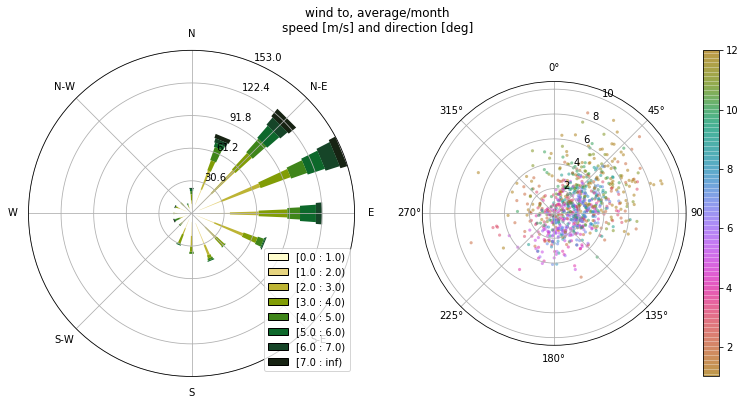

In [4]:
# create a wide figure, showing 2 wind roses with some extra info
fig = plt.figure(figsize=(13, 6))
# TODO: check from/to
# we're creating 2 windroses, one boxplot
ax = fig.add_subplot(1, 2, 1, projection='windrose')
ax = windrose.WindroseAxes.from_ax(ax=ax)
# from radians 0 east, ccw to 0 north cw
wind_direction_deg = np.mod(90 - (360.0 * wind_df.direction / (2*np.pi)), 360)
# create a box plot
ax.box(wind_direction_deg, wind_df.speed, bins=np.arange(0, 8, 1), cmap=cmocean.cm.speed)
ax.legend(loc='lower right')

# and a scatter showing the seasonal pattern (colored by month)
ax = fig.add_subplot(1, 2, 2, 
    projection='polar',
    theta_direction=-1,
    theta_offset=np.pi/2.0
)
N = matplotlib.colors.Normalize(1, 12)
months = wind_df.t.apply(lambda x:x.month)
sc = ax.scatter(
    (np.pi/2)-wind_df.direction, 
    wind_df.speed, 
    c=months, 
    cmap=cmocean.cm.phase, 
    vmin=1, 
    vmax=12,
    alpha=0.5,
    s=10,
    edgecolor='none'
)
_ = plt.colorbar(sc, ax=ax)
_ = fig.suptitle('wind to, average/month\nspeed [m/s] and direction [deg]')

Sea-level measurements
=============
In this section we download sea-level measurements. The global collection of tide gauge records at the PSMSL is used to access the data. The other way to access the data is to ask the service desk data at Rijkswaterstaat. There are two types of datasets the "Revised Local Reference" and "Metric". For the Netherlands the difference is that the "Revised Local Reference" undoes the corrections from the  NAP correction in 2014, to get a consistent dataset. Here we transform the RLR back to NAP (without undoing the correction).

In [5]:
urls = {
    'metric_monthly': 'http://www.psmsl.org/data/obtaining/met.monthly.data/met_monthly.zip',
    'rlr_monthly': 'http://www.psmsl.org/data/obtaining/rlr.monthly.data/rlr_monthly.zip',
    'rlr_annual': 'http://www.psmsl.org/data/obtaining/rlr.annual.data/rlr_annual.zip'
}
dataset_name = 'rlr_monthly'

In [6]:
# these compute the rlr back to NAP (ignoring the undoing of the NAP correction)
main_stations = {
    20: {
        'name': 'Vlissingen', 
        'rlr2nap': lambda x: x - (6976-46)
    },
    22: {
        'name': 'Hoek van Holland', 
        'rlr2nap': lambda x:x - (6994 - 121)
    },
    23: {
        'name': 'Den Helder', 
        'rlr2nap': lambda x: x - (6988-42)
    },
    24: {
        'name': 'Delfzijl', 
        'rlr2nap': lambda x: x - (6978-155)
    },
    25: {
        'name': 'Harlingen', 
        'rlr2nap': lambda x: x - (7036-122)
    },
    32: {
        'name': 'IJmuiden', 
        'rlr2nap': lambda x: x - (7033-83)
    }
}

In [7]:
# the main stations are defined by their ids
main_stations_idx = list(main_stations.keys())
main_stations_idx

[32, 20, 22, 23, 24, 25]

In [8]:
# download the zipfile
resp = requests.get(urls[dataset_name])

# we can read the zipfile
stream = io.BytesIO(resp.content)
zf = zipfile.ZipFile(stream)

# this list contains a table of 
# station ID, latitude, longitude, station name, coastline code, station code, and quality flag
csvtext = zf.read('{}/filelist.txt'.format(dataset_name))

stations = pandas.read_csv(
    io.BytesIO(csvtext), 
    sep=';',
    names=('id', 'lat', 'lon', 'name', 'coastline_code', 'station_code', 'quality'),
    converters={
        'name': str.strip,
        'quality': str.strip
    }
)
stations = stations.set_index('id')

# the dutch stations in the PSMSL database, make a copy
# or use stations.coastline_code == 150 for all dutch stations
selected_stations = stations.ix[main_stations_idx].copy()
# set the main stations, this should be a list of 6 stations
selected_stations

,lat,lon,name,coastline_code,station_code,quality
id,,,,,,
32,52.462222,4.554722,IJMUIDEN,150,41,N
20,51.442222,3.596111,VLISSINGEN,150,101,N
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N
23,52.964444,4.745000,DEN HELDER,150,31,N
24,53.326389,6.933056,DELFZIJL,150,1,N
25,53.175556,5.409444,HARLINGEN,150,21,N


In [9]:
# show all the stations on a map

# compute the bounds of the plot
sw = (50, -5)
ne = (55, 10)
# transform to web mercator
sw_wm = pyproj.transform(WGS84, WEBMERCATOR, sw[1], sw[0])
ne_wm = pyproj.transform(WGS84, WEBMERCATOR, ne[1], ne[0])
# create a plot
fig = bokeh.plotting.figure(tools='pan, wheel_zoom', plot_width=600, plot_height=200, x_range=(sw_wm[0], ne_wm[0]), y_range=(sw_wm[1], ne_wm[1]))
fig.axis.visible = False
# add some background tiles
fig.add_tile(bokeh.tile_providers.STAMEN_TERRAIN)
# add the stations
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(stations.lon), np.array(stations.lat))
fig.circle(x, y)
x, y = pyproj.transform(WGS84, WEBMERCATOR, np.array(selected_stations.lon), np.array(selected_stations.lat))
_ = fig.circle(x, y, color='red')


In [10]:
# show the plot
bokeh.io.show(fig)

Now that we have defined which tide gauges we are monitoring we can start downloading the relevant data. 

In [11]:
# each station has a number of files that you can look at.
# here we define a template for each filename

# stations that we are using for our computation
# define the name formats for the relevant files
names = {
    'datum': '{dataset}/RLR_info/{id}.txt',
    'diagram': '{dataset}/RLR_info/{id}.png',
    'url': 'http://www.psmsl.org/data/obtaining/rlr.diagrams/{id}.php',
    'data': '{dataset}/data/{id}.rlrdata',
    'doc': '{dataset}/docu/{id}.txt',
    'contact': '{dataset}/docu/{id}_auth.txt'
}

In [12]:
def get_url(station, dataset):
    """return the url of the station information (diagram and datum)"""
    info = dict(
        dataset=dataset,
        id=station.name
    )
    url = names['url'].format(**info)
    return url
# fill in the dataset parameter using the global dataset_name
f = functools.partial(get_url, dataset=dataset_name)
# compute the url for each station
selected_stations['url'] = selected_stations.apply(f, axis=1)
selected_stations

,lat,lon,name,coastline_code,station_code,quality,url
id,,,,,,,
32,52.462222,4.554722,IJMUIDEN,150,41,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
20,51.442222,3.596111,VLISSINGEN,150,101,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
22,51.977500,4.120000,HOEK VAN HOLLAND,150,51,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
23,52.964444,4.745000,DEN HELDER,150,31,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
24,53.326389,6.933056,DELFZIJL,150,1,N,http://www.psmsl.org/data/obtaining/rlr.diagra...
25,53.175556,5.409444,HARLINGEN,150,21,N,http://www.psmsl.org/data/obtaining/rlr.diagra...


In [13]:
def missing2nan(value, missing=-99999):
    """convert the value to nan if the float of value equals the missing value"""
    value = float(value)
    if value == missing:
        return np.nan
    return value

def year2date(year_fraction, dtype):
    startpoints = np.linspace(0, 1, num=12, endpoint=False)
    remainder = np.mod(year_fraction, 1)
    year = np.floor_divide(year_fraction, 1).astype('int')
    month = np.searchsorted(startpoints, remainder)
    dates = [
        datetime.datetime(year_i, month_i, 1) 
        for year_i, month_i 
        in zip(year, month)
    ]
    datetime64s = np.asarray(dates, dtype=dtype)
    return datetime64s

def get_data(station, dataset):
    """get data for the station (pandas record) from the dataset (url)"""
    info = dict(
        dataset=dataset,
        id=station.name
    )
    bytes = zf.read(names['data'].format(**info))
    df = pandas.read_csv(
        io.BytesIO(bytes), 
        sep=';', 
        names=('year', 'height', 'interpolated', 'flags'),
        converters={
            "height": lambda x: main_stations[station.name]['rlr2nap'](missing2nan(x)),
            "interpolated": str.strip,
        }
    )
    df['station'] = station.name
    df['t'] = year2date(df.year, dtype=wind_df.t.dtype)
    # merge the wind and water levels
    merged = pandas.merge(df, wind_df, how='left', on='t')
    merged['u2'] = np.where(np.isnan(merged['u']), np.nanmean(merged['u']**2), merged['u']**2)
    merged['v2'] = np.where(np.isnan(merged['v']), np.nanmean(merged['v']**2), merged['v']**2)
    return merged

In [14]:
# get data for all stations
f = functools.partial(get_data, dataset=dataset_name)
# look up the data for each station
selected_stations['data'] = [f(station) for _, station in selected_stations.iterrows()]

Now that we have all data downloaded we can compute the mean.

In [15]:
# compute the mean
grouped = pandas.concat(selected_stations['data'].tolist())[['year', 't', 'height', 'u', 'v', 'u2', 'v2']].groupby(['year', 't'])
mean_df = grouped.mean().reset_index()
# filter out non-trusted part (before NAP)
mean_df = mean_df[mean_df['year'] >= 1890].copy()

In [16]:
# these are the mean waterlevels 
mean_df.tail()

,year,t,height,u,v,u2,v2
1843,2015.6250,2015-08-01,46.666667,0.500000,1.275806,0.250000,1.627682
1844,2015.7084,2015-09-01,106.666667,1.139167,0.055833,1.297702,0.003117
1845,2015.7916,2015-10-01,34.500000,-1.252419,-0.153226,1.568555,0.023478
1846,2015.8750,2015-11-01,372.166667,6.756666,3.262500,45.652538,10.643904
1847,2015.9584,2015-12-01,185.333333,4.776613,7.488709,22.816029,56.080761


In [17]:
# show all the stations, including the mean
title = 'Sea-surface height for Dutch tide gauges [{year_min} - {year_max}]'.format(
    year_min=mean_df.year.min(),
    year_max=mean_df.year.max() 
)
fig = bokeh.plotting.figure(title=title, x_range=(1860, 2020), plot_width=900, plot_height=400)
colors = bokeh.palettes.Accent6
for color, (id_, station) in zip(colors, selected_stations.iterrows()):
    data = station['data']
    fig.circle(data.year, data.height, color=color, legend=station['name'], alpha=0.5, line_width=1)
fig.line(mean_df.year, mean_df.height, line_width=1, alpha=0.7, color='black', legend='Mean')
fig.legend.location = "bottom_right"
fig.yaxis.axis_label = 'waterlevel [mm] above NAP'
fig.xaxis.axis_label = 'year'



In [18]:
bokeh.io.show(fig)

Methods
=====
Now we can define the statistical model. The "current sea-level rise" is defined by the following formula. Please note that the selected epoch of 1970 is arbitrary. 
$
H(t) = a + b_{trend}(t-1970) + b_u\cos(2\pi\frac{t - 1970}{18.613}) + b_v\sin(2\pi\frac{t - 1970}{18.613}) + b_{wind_u^2}wind_u(t)^2 + b_{wind_v^2}wind_v(t)^2
$

The terms are refered to as Constant ($a$), Trend ($b_{trend}$), Nodal U ($b_u$) and Nodal V ($b_v$), Wind $U^2$ ($b_{wind_u^2}$) and  Wind $V^2$ ($b_{wind_v^2}$). 


Alternative models are used to detect if sea-level rise is increasing. These models include the broken linear model, defined by a possible change in trend starting at 1993. This timespan is the start of the "satellite era" (start of TOPEX/Poseidon measurements), it is also often referred to as the start of acceleration because the satellite measurements tend to show a higher rate of sea level than the "tide-gauge era" (1900-2000). If this model fits better than the linear model, one could say that there is a "increase in sea-level rise". 

$
H(t) = a + b_{trend}(t-1970) + b_{broken}(t > 1993)*(t-1993) + b_{u}\cos(2\pi\frac{t - 1970}{18.613}) + b_{v}\sin(2\pi\frac{t - 1970}{18.613})
$

Another way to look at increased sea-level rise is to look at sea-level acceleration. To detect sea-level acceleration one can use a quadratic model. 

$
H(t) = a + b_{trend}(t-1970) + b_{quadratic}(t - 1970)*(t-1970) + b_{u}\cos(2\pi\frac{t - 1970}{18.613}) + b_{v}\sin(2\pi\frac{t - 1970}{18.613})
$


In [19]:
# define the statistical model
def linear_model(df, with_wind=True, with_season=True):
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    month = np.mod(df['year'], 1) * 12.0
    names = ['Constant', 'Trend', 'Nodal U', 'Nodal V']
    if with_wind:
        X = np.c_[
            X, 
            df['u2'],
            df['v2']
        ]
        names.extend(['Wind U^2', 'Wind V^2'])
    if with_season:
        for i in range(11):
            X = np.c_[
                X,
                np.logical_and(month >= i, month < i+1)
            ]
            names.append('month_%s' % (i+1, ))
    X = sm.add_constant(X)
    model = sm.OLS(y, X, missing='drop')
    fit = model.fit()
    return fit, names

In [20]:

linear_with_wind_fit, names = linear_model(mean_df, with_wind=True, with_season=False)
print('Linear model with wind (1948-current)')
table = linear_with_wind_fit.summary(
    yname='Sea-surface height', 
    xname=names
)
IPython.display.display(table)
linear_fit, names = linear_model(mean_df, with_wind=False, with_season=False)
print('Linear model without (1890-current)')
table = linear_fit.summary(yname='Sea-surface height', xname=names)
IPython.display.display(table)

if (linear_fit.aic < linear_with_wind_fit.aic):
    print('The linear model without wind is a higher quality model (smaller AIC) than the linear model with wind.')
else:
    print('The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.')

# things to check:
# Durbin Watson should be >1 for no worries, >2 for no autocorrelation
# JB should be non-significant for normal residuals
# abs(x2.t) + abs(x3.t) should be > 3, otherwise adding nodal is not useful

Linear model with wind (1948-current)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.449
Model:                            OLS   Adj. R-squared:                  0.447
Method:                 Least Squares   F-statistic:                     245.5
Date:                Mon, 15 May 2017   Prob (F-statistic):          4.98e-192
Time:                        23:24:52   Log-Likelihood:                -9033.7
No. Observations:                1512   AIC:                         1.808e+04
Df Residuals:                    1506   BIC:                         1.811e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -81.3768      3.995    -20.370      0.000     -89.213     -73.541
Trend          1.8636      0.068     27.507      0.000       1.731       1.996
Nodal U        8.1883      3.495      2.343      0.019       1.333      15.043
Nodal V      -10.2712      3.462     -2.967      0.003     -17.062      -3.480
Wind U^2       6.4245      0.330     19.485      0.000       5.778       7.071
Wind V^2       1.7193      0.480      3.584      0.000       0.778       2.660
==============================================================================
Omnibus:                      176.142   Durbin-Watson:                   1.416
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              672.907
Skew:                          -0.519   Prob(JB):                    7.59e-147
Kurtosis:                       6.099   Cond. No.                         65.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Linear model without (1890-current)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     206.7
Date:                Mon, 15 May 2017   Prob (F-statistic):          2.79e-112
Time:                        23:24:52   Log-Likelihood:                -9224.1
No. Observations:                1512   AIC:                         1.846e+04
Df Residuals:                    1508   BIC:                         1.848e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -26.0825      3.073     -8.487      0.000     -32.111     -20.054
Trend          1.9082      0.077     24.869      0.000       1.758       2.059
Nodal U        8.1427      3.961      2.056      0.040       0.374      15.911
Nodal V      -10.4891      3.923     -2.674      0.008     -18.185      -2.793
==============================================================================
Omnibus:                       22.273   Durbin-Watson:                   1.397
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.396
Skew:                           0.185   Prob(JB):                     4.14e-07
Kurtosis:                       3.574   Cond. No.                         57.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The linear model with wind is a higher quality model (smaller AIC) than the linear model without wind.


In [21]:
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
fig.circle(mean_df.year, mean_df.height, line_width=1, legend='Monthly mean sea level', color='black', alpha=0.5)
fig.line(
    linear_with_wind_fit.model.exog[:, 1] + 1970, 
    linear_with_wind_fit.predict(), 
    line_width=3, 
    alpha=0.5,
    legend='Current sea level, corrected for wind influence'
)
fig.line(
    linear_fit.model.exog[:, 1] + 1970, 
    linear_fit.predict(), 
    line_width=3, 
    legend='Current sea level', 
    color='green',
    alpha=0.5
)
fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
bokeh.io.show(fig)

Regional variability
=====================
It is known that the sea-level rise is not constant along the coast. The figures below show that the sea-level is rising faster at some stations. Some of these variations go back to the 1900's. 

In [22]:
p = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
colors = bokeh.palettes.Accent6

for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station['data'].ix[station['data'].year >= 1890]
    fit, names = linear_with_wind_fit, names = linear_model(df, with_wind=False, with_season=False)
    print(station['name'])
    smry = fit.summary(xname=names)
    IPython.display.display(smry.tables[1])
    p.circle(station['data'].year, station['data'].height, alpha=0.1, color=color)
# loop again so we have the lines on top
for color, (name, station) in zip(colors, selected_stations.iterrows()):
    df = station['data'].ix[station['data'].year >= 1890]
    fit, names = linear_with_wind_fit, names = linear_model(df, with_wind=False, with_season=False)
    p.line(
        fit.model.exog[:, 1] + 1970, 
        fit.predict(), 
        line_width=3, 
        alpha=0.8,
        legend=station['name'],
        color=color
    )
bokeh.io.show(p)


IJMUIDEN


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,-45.4173,3.086,-14.718,0.000,-51.470,-39.364
Trend,2.1300,0.077,27.647,0.000,1.979,2.281
Nodal U,14.0500,3.977,3.533,0.000,6.249,21.851
Nodal V,-12.0656,3.939,-3.063,0.002,-19.793,-4.338


VLISSINGEN


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,-78.6321,2.465,-31.902,0.000,-83.467,-73.797
Trend,2.1686,0.062,35.240,0.000,2.048,2.289
Nodal U,7.7598,3.176,2.443,0.015,1.529,13.991
Nodal V,-12.1750,3.147,-3.869,0.000,-18.347,-6.003


HOEK VAN HOLLAND


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,-9.4397,2.756,-3.426,0.001,-14.845,-4.035
Trend,2.3735,0.069,34.500,0.000,2.239,2.508
Nodal U,2.9859,3.551,0.841,0.401,-3.980,9.952
Nodal V,-8.9682,3.518,-2.549,0.011,-15.869,-2.068


DEN HELDER


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,-60.8488,3.257,-18.680,0.000,-67.238,-54.459
Trend,1.5049,0.081,18.503,0.000,1.345,1.664
Nodal U,9.0418,4.198,2.154,0.031,0.807,17.276
Nodal V,-11.3802,4.159,-2.737,0.006,-19.537,-3.223


DELFZIJL


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,25.8902,3.679,7.038,0.000,18.674,33.106
Trend,1.9519,0.092,21.252,0.000,1.772,2.132
Nodal U,8.7026,4.741,1.836,0.067,-0.597,18.002
Nodal V,-10.1256,4.696,-2.156,0.031,-19.337,-0.914


HARLINGEN


,coef,std err,t,P>|t|,[0.025,0.975]
Constant,11.9527,3.775,3.166,0.002,4.547,19.358
Trend,1.3202,0.094,14.006,0.000,1.135,1.505
Nodal U,6.3159,4.865,1.298,0.194,-3.228,15.860
Nodal V,-8.2200,4.820,-1.705,0.088,-17.674,1.234


Using the mean of the six tidal guages is the current approach. There are alternatives, for example one can use the principal component of the differences (between months/years). It is then assumed that only the common variance shared accross all stations is representative of the shared sea level. Most of the variance is shared between all stations and this results in a similar trend as using the mean. This method is referred to as EOF, PCA or SSA. 

In [170]:
dfs = []
names = []
for color, (id, station) in zip(colors, selected_stations.iterrows()):
    df = station['data'].ix[station['data'].year >= 1890]
    dfs.append(df.set_index('year')['height'])
    names.append(station['name'])
merged = pandas.concat(dfs, axis=1)
merged.columns = names
diffs = np.array(merged.diff())
pca = statsmodels.multivariate.pca.PCA(diffs[1:])
df = pandas.DataFrame(data=dict(year=merged.index[1:],  height=np.cumsum(pca.project(1)[:, 0])))
fit, names = linear_model(df, with_wind=False, with_season=False)
p = bokeh.plotting.figure()
p.circle(merged.index[1:], np.cumsum(pca.project(1)[:, 0]))
p.line(
        fit.model.exog[:, 1] + 1970, 
        fit.predict(), 
        line_width=3, 
        alpha=0.8,
        legend='First EOF',
        color=color
    )
IPython.display.display(fit.summary(xname=names))
bokeh.io.show(p)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 height   R-squared:                       0.368
Model:                            OLS   Adj. R-squared:                  0.367
Method:                 Least Squares   F-statistic:                     292.8
Date:                Tue, 16 May 2017   Prob (F-statistic):          9.35e-150
Time:                        11:56:52   Log-Likelihood:                -9144.9
No. Observations:                1511   AIC:                         1.830e+04
Df Residuals:                    1507   BIC:                         1.832e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant      67.0666      2.928     22.904      0.000      61.323      72.810
Trend          2.1678      0.073     29.625      0.000       2.024       2.311
Nodal U        7.9525      3.774      2.107      0.035       0.550      15.355
Nodal V      -10.2608      3.740     -2.743      0.006     -17.597      -2.925
==============================================================================
Omnibus:                       21.091   Durbin-Watson:                   1.381
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               27.054
Skew:                           0.186   Prob(JB):                     1.33e-06
Kurtosis:                       3.540   Cond. No.                         57.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Is there a sea-level acceleration?
==================

The following section computes two common models to detect sea-level acceleration.  The broken linear model expects that sea level has been rising faster since 1990. The quadratic model assumes that the sea-level is accelerating continuously. Both models are compared to the linear model. The extra terms are tested for significance and the AIC is computed to see which model is "better". 

In [23]:
# define the statistical model
def broken_linear_model(df):
    """This model fits the sea-level rise has started to rise faster in 1993."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] > 1993) * (df['year'] - 1993),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    X = sm.add_constant(X)
    model_broken_linear = sm.OLS(y, X)
    fit = model_broken_linear.fit()
    return fit
broken_linear_fit = broken_linear_model(mean_df)

In [24]:
# define the statistical model
def quadratic_model(df):
    """This model computes a parabolic linear fit. This corresponds to the hypothesis that sea-level is accelerating."""
    y = df['height']
    X = np.c_[
        df['year']-1970, 
        (df['year'] - 1970) * (df['year'] - 1970),
        np.cos(2*np.pi*(df['year']-1970)/18.613),
        np.sin(2*np.pi*(df['year']-1970)/18.613)
    ]
    X = sm.add_constant(X)
    model_quadratic = sm.OLS(y, X)
    fit = model_quadratic.fit()
    return fit
quadratic_fit = quadratic_model(mean_df)

In [25]:
# summary of the broken linear model
broken_linear_fit.summary(yname='Sea-surface height', xname=['Constant', 'Trend', 'Trend(year > 1993)', 'Nodal U', 'Nodal V'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.292
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     155.5
Date:                Mon, 15 May 2017   Prob (F-statistic):          1.78e-111
Time:                        23:24:53   Log-Likelihood:                -9223.2
No. Observations:                1512   AIC:                         1.846e+04
Df Residuals:                    1507   BIC:                         1.848e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Constant             -29.2620      3.883     -7.535      0.000     -36.879     -21.645
Trend                  1.8305      0.096     19.034      0.000       1.642       2.019
Trend(year > 1993)     0.8912      0.666      1.339      0.181      -0.415       2.197
Nodal U                8.0054      3.961      2.021      0.043       0.236      15.775
Nodal V              -10.9666      3.938     -2.784      0.005     -18.692      -3.241
==============================================================================
Omnibus:                       22.786   Durbin-Watson:                   1.399
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.645
Skew:                           0.194   Prob(JB):                     3.65e-07
Kurtosis:                       3.566   Cond. No.                         57.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
# summary of the quadratic model
quadratic_fit.summary(yname='Sea-surface height', xname=['Constant', 'Trend', 'Trend**2', 'Nodal U', 'Nodal V'])


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     Sea-surface height   R-squared:                       0.291
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     155.0
Date:                Mon, 15 May 2017   Prob (F-statistic):          3.82e-111
Time:                        23:24:53   Log-Likelihood:                -9224.0
No. Observations:                1512   AIC:                         1.846e+04
Df Residuals:                    1507   BIC:                         1.848e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Constant     -27.3302      3.917     -6.977      0.000     -35.013     -19.647
Trend          1.9494      0.111     17.565      0.000       1.732       2.167
Trend**2       0.0012      0.002      0.514      0.607      -0.003       0.006
Nodal U        7.9964      3.972      2.013      0.044       0.206      15.787
Nodal V      -10.5777      3.928     -2.693      0.007     -18.283      -2.873
==============================================================================
Omnibus:                       22.388   Durbin-Watson:                   1.398
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               29.395
Skew:                           0.188   Prob(JB):                     4.14e-07
Kurtosis:                       3.571   Cond. No.                     3.40e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.4e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

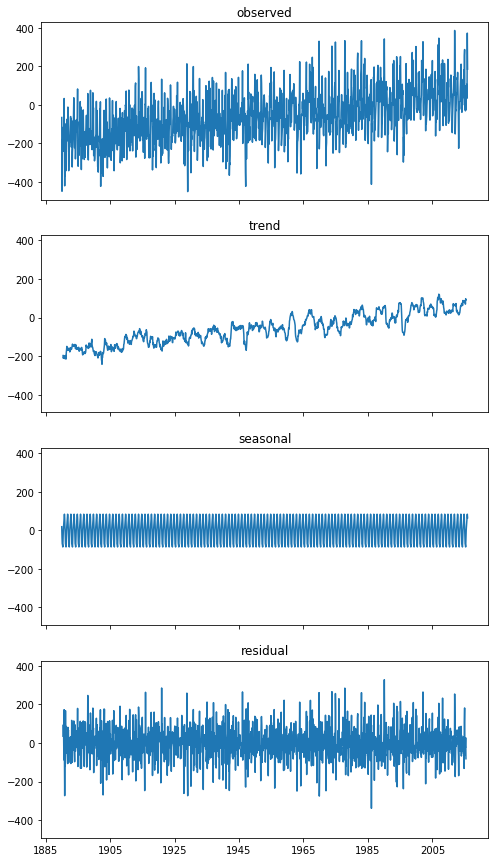

In [86]:
import statsmodels.tsa.seasonal
# mean_df.set_index(''))
n_year = 1
# 1 year moving average window used as filter 
filt = np.repeat(1./(12*n_year), 12*n_year)
seasonal_decompose_fit = statsmodels.tsa.seasonal.seasonal_decompose(mean_df.set_index('t')['height'], freq=12, filt=filt)
fig, axes = plt.subplots(4, 1, sharex=True, sharey=True, figsize=(8, 15)) 
axes[0].plot(mean_df.t, seasonal_decompose_fit.observed)
axes[0].set_title('observed')
axes[1].plot(mean_df.t, seasonal_decompose_fit.trend)
axes[1].set_title('trend')
axes[2].plot(mean_df.t, seasonal_decompose_fit.seasonal)
axes[2].set_title('seasonal')
axes[3].plot(mean_df.t, seasonal_decompose_fit.resid)
axes[3].set_title('residual')



In [27]:
fig = bokeh.plotting.figure(x_range=(1860, 2020), plot_width=900, plot_height=400)
fig.circle(mean_df.year, mean_df.height, line_width=3, legend='Mean', color='black', alpha=0.5)
fig.line(mean_df.year, linear_fit.predict(), line_width=3, legend='Current')
fig.line(mean_df.year, broken_linear_fit.predict(), line_width=3, color='#33bb33', legend='Broken')
fig.line(mean_df.year, quadratic_fit.predict(), line_width=3, color='#3333bb', legend='Quadratic')

fig.legend.location = "top_left"
fig.yaxis.axis_label = 'waterlevel [mm] above N.A.P.'
fig.xaxis.axis_label = 'year'
bokeh.io.show(fig)

Conclusions
======
Below are some statements that depend on the output calculated above. 

In [28]:
msg = '''The current average waterlevel above NAP (in mm), 
based on the 6 main tide gauges for the year {year} is {height:.1f} cm.
The current sea-level rise is {rate:.0f} cm/century'''
print(msg.format(year=mean_df['year'].iloc[-1], height=linear_fit.predict()[-1]/10.0, rate=linear_fit.params.x1*100.0/10))

The current average waterlevel above NAP (in mm), 
based on the 6 main tide gauges for the year 2015.9584 is 5.2 cm.
The current sea-level rise is 19 cm/century


In [29]:
if (linear_fit.aic < broken_linear_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the broken linear model.')
else:
    print('The broken linear model is a higher quality model (smaller AIC) than the linear model.')
if (broken_linear_fit.pvalues['x2'] < 0.05):
    print('The trend break is bigger than we would have expected under the assumption that there was no trend break.')
else:
    print('Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.')

The linear model is a higher quality model (smaller AIC) than the broken linear model.
Under the assumption that there is no trend break, we would have expected a trend break as big as we have seen.


In [30]:
if (linear_fit.aic < quadratic_fit.aic):
    print('The linear model is a higher quality model (smaller AIC) than the quadratic model.')
else:
    print('The quadratic model is a higher quality model (smaller AIC) than the linear model.')
if (quadratic_fit.pvalues['x2'] < 0.05):
    print('The quadratic term is bigger than we would have expected under the assumption that there was no quadraticness.')
else:
    print('Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.')

The linear model is a higher quality model (smaller AIC) than the quadratic model.
Under the assumption that there is no quadraticness, we would have expected a quadratic term as big as we have seen.
